In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import cv2
import itertools
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATASET = "D:/AIP490/dataset/data"

In [3]:
image_dir = Path(DATASET)
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)

labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
image_df

,Filepath,Label
0,D:\AIP490\dataset\data\Banh bao\Banh bao1.jpg,Banh bao
1,D:\AIP490\dataset\data\Banh bao\Banh bao10.jpg,Banh bao
2,D:\AIP490\dataset\data\Banh bao\Banh bao100.jpg,Banh bao
3,D:\AIP490\dataset\data\Banh bao\Banh bao1000.jpg,Banh bao
4,D:\AIP490\dataset\data\Banh bao\Banh bao1001.jpg,Banh bao
...,...,...
97998,D:\AIP490\dataset\data\Xoi xeo\Xoi xeo995.jpg,Xoi xeo
97999,D:\AIP490\dataset\data\Xoi xeo\Xoi xeo996.jpg,Xoi xeo
98000,D:\AIP490\dataset\data\Xoi xeo\Xoi xeo997.jpg,Xoi xeo
98001,D:\AIP490\dataset\data\Xoi xeo\Xoi xeo998.jpg,Xoi xeo


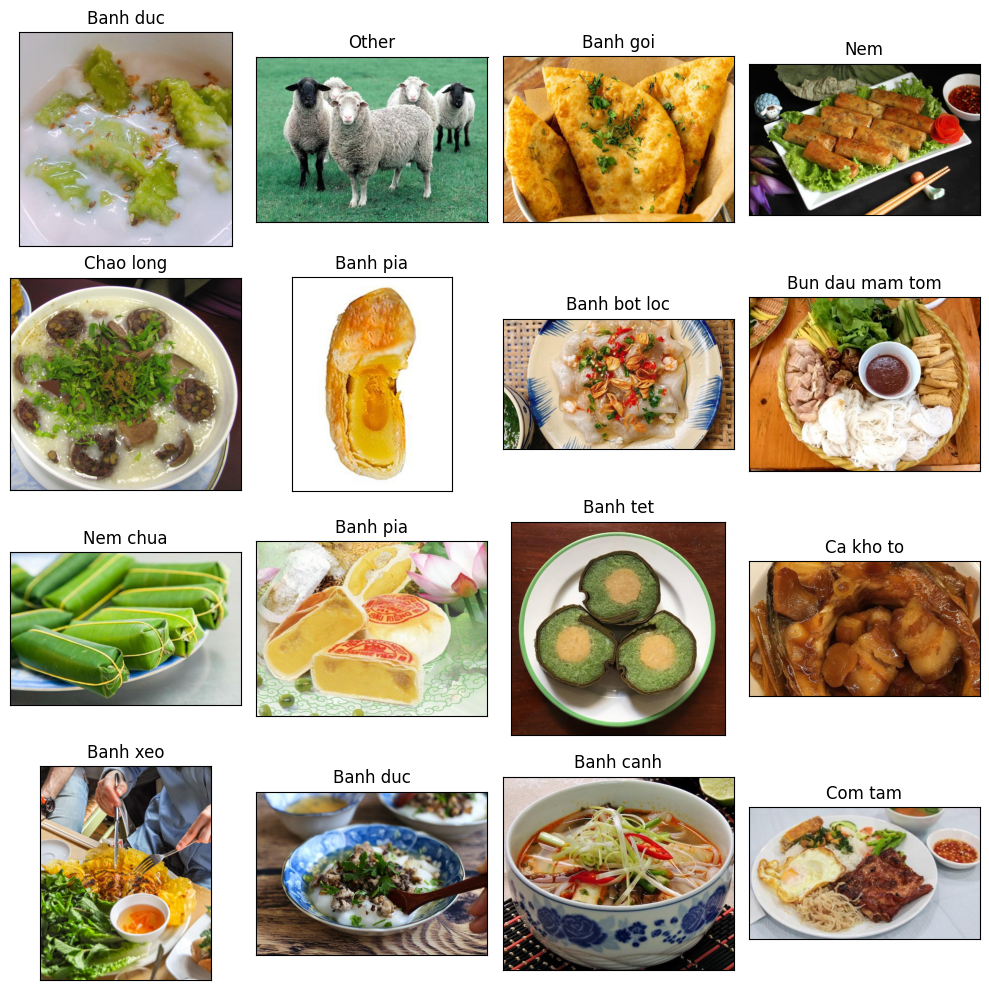

In [5]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [7]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 62722 validated image filenames belonging to 51 classes.
Found 15680 validated image filenames belonging to 51 classes.
Found 19601 validated image filenames belonging to 51 classes.


In [12]:
a = train_images.class_indices
classes = list(a.keys())
classes

['Banh bao',
 'Banh beo',
 'Banh bot loc',
 'Banh can',
 'Banh canh',
 'Banh chung',
 'Banh cuon',
 'Banh da',
 'Banh day',
 'Banh duc',
 'Banh gio',
 'Banh goi',
 'Banh mi',
 'Banh pia',
 'Banh tet',
 'Banh trang nuong',
 'Banh xeo',
 'Bun bo Hue',
 'Bun dau mam tom',
 'Bun mam',
 'Bun rieu',
 'Bun thit nuong',
 'Ca kho to',
 'Canh chua',
 'Canh cua',
 'Cao lau',
 'Cha muc',
 'Chao long',
 'Com tam',
 'Doi',
 'Ga luoc',
 'Gio lua',
 'Goi cuon',
 'Heo quay',
 'Hu tieu',
 'Keo lac',
 'Khoai nuong',
 'Mi quang',
 'Muc chien',
 'Nem',
 'Nem chua',
 'Ngo',
 'Other',
 'Pho',
 'Pho cuon',
 'Thit kho tau',
 'Thit xien',
 'Trau gac bep',
 'Trung vit lon',
 'Vit quay',
 'Xoi xeo']

In [13]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224,224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

In [79]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [80]:
checkpoint_path = "insect_classification_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [82]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [84]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(51, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
3921/3921 [==============================] - 3659s 932ms/step - loss: 3.1062 - accuracy: 0.2420 - val_loss: 1.9618 - val_accuracy: 0.5460
Epoch 2/50
3921/3921 [==============================] - 3487s 889ms/step - loss: 1.8616 - accuracy: 0.5051 - val_loss: 1.2295 - val_accuracy: 0.6951
Epoch 3/50
3921/3921 [==============================] - 3505s 894ms/step - loss: 1.4124 - accuracy: 0.6103 - val_loss: 0.9734 - val_accuracy: 0.7474
Epoch 4/50
3921/3921 [==============================] - 3491s 890ms/step - loss: 1.1889 - accuracy: 0.6640 - val_loss: 0.8374 - val_accuracy: 0.7740
Epoch 5/50
3921/3921 [==============================] - 3545s 904ms/step - loss: 1.0511 - accuracy: 0.6993 - val_loss: 0.7494 - val_accuracy: 0.7952
Epoch 6/50
3921/3921 [==============================] - 3577s 912ms/step - loss: 0.9532 - accuracy: 0.7260 - val_loss: 0.6877 - val_accuracy: 0.8083
Epoch 7/50
3921/3921 [==============================] - 3534s 901ms/step - loss: 0.8807 - accuracy: 0.7471

In [85]:
model.save("model_mobileNetV3.h5")

d:\AIP490\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
model = keras.models.load_model("./model_mobileNetV3.h5")

In [91]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.21438
Test Accuracy: 93.91%


In [88]:
pretrained_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_7[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [114]:
initial_epochs = len(history.history['accuracy'])

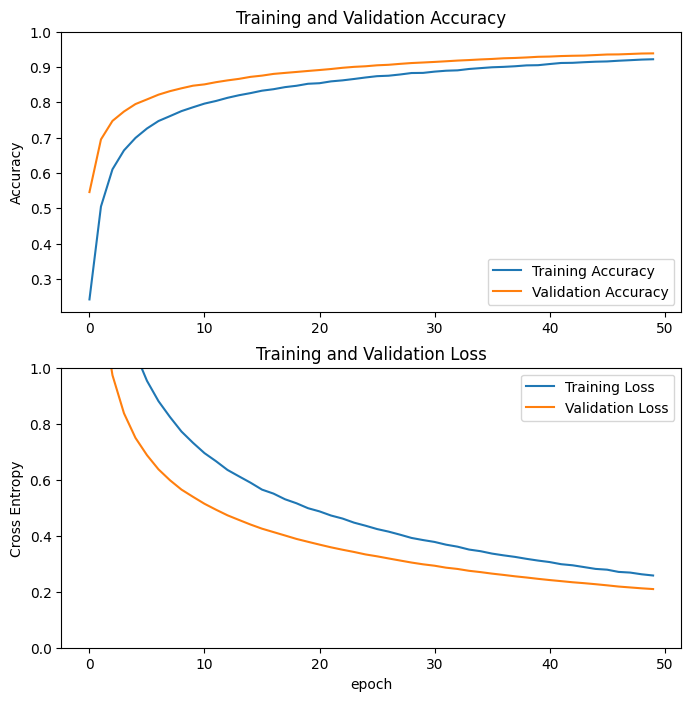

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [96]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

1226/1226 [==============================] - 1221s 993ms/step


In [98]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Banh bao,0.983847,0.994065,0.988930,674.000000
Banh beo,0.962730,0.990816,0.976571,1851.000000
Banh bot loc,0.900857,0.896468,0.898657,821.000000
Banh can,0.964215,0.978809,0.971457,991.000000
Banh canh,0.793363,0.737728,0.764535,713.000000
Banh chung,0.945758,0.960452,0.953048,708.000000
Banh cuon,0.897661,0.884726,0.891147,694.000000
Banh da,0.982014,0.982014,0.982014,556.000000
Banh day,0.971875,0.967341,0.969602,643.000000
Banh duc,0.913863,0.838272,0.874437,810.000000


In [107]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(25, 25), text_size=10, norm=False, savefig=False): 

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig(".\confusion_matrix.png")

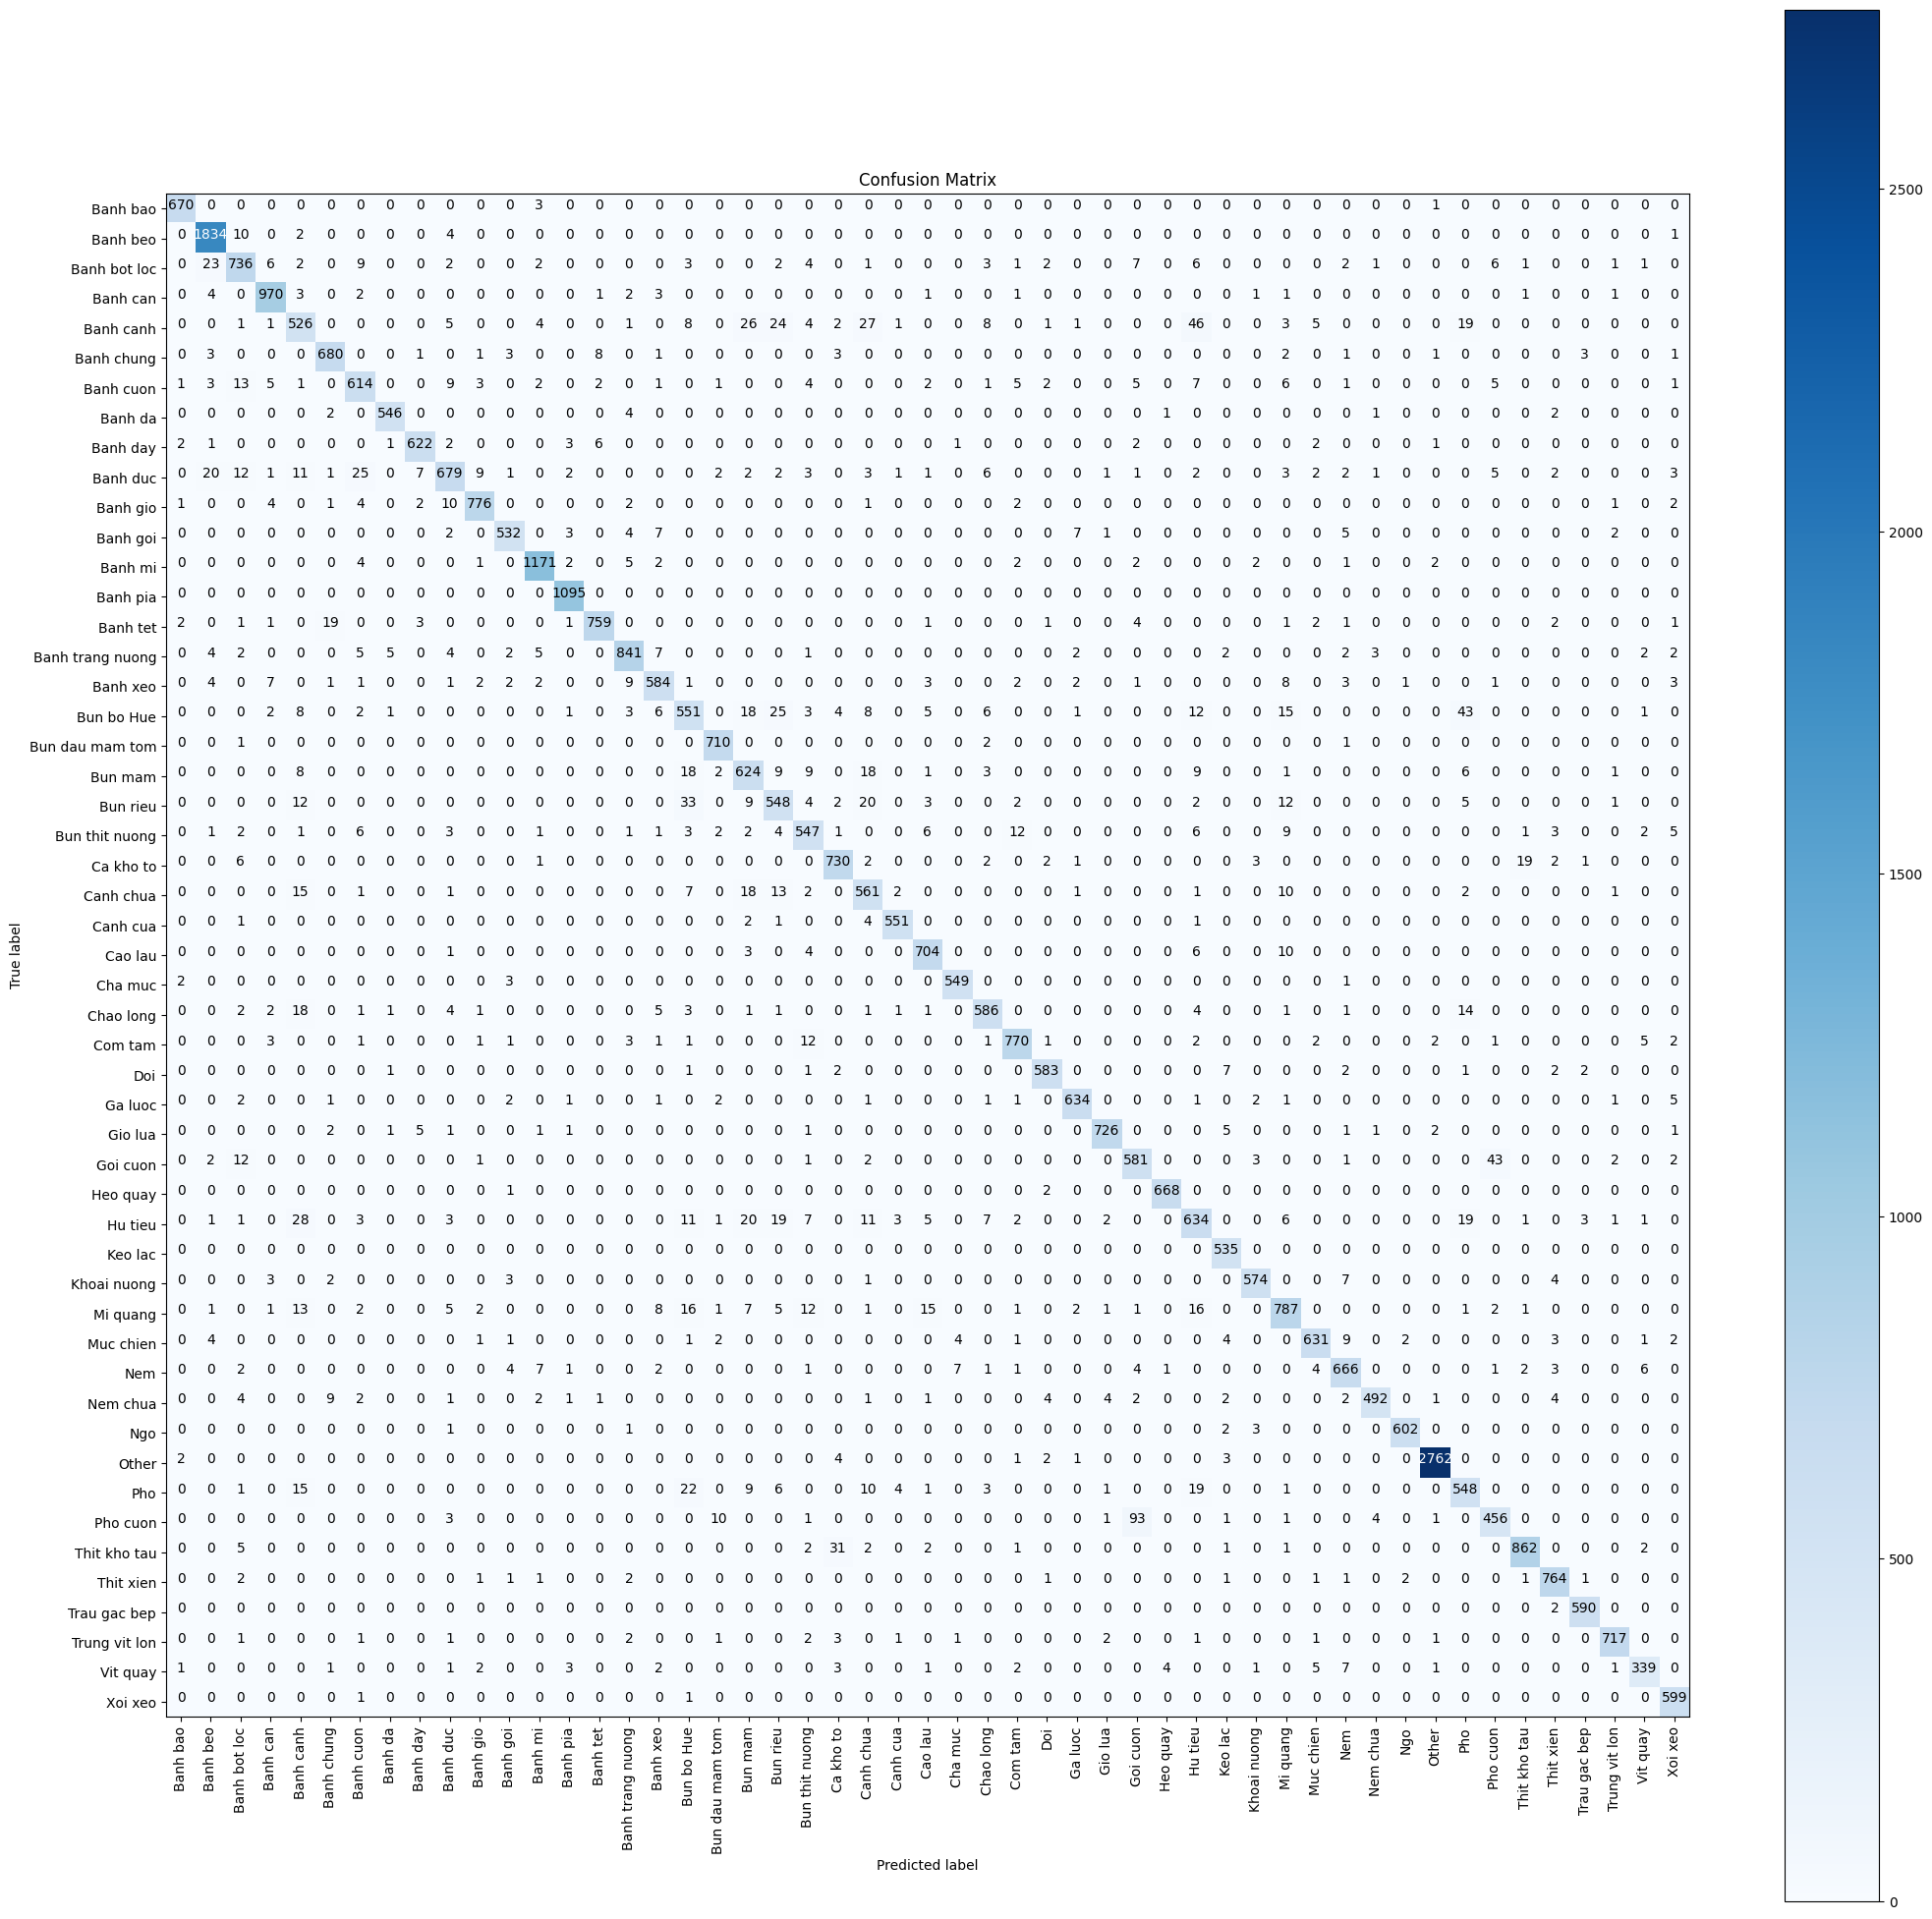

In [108]:
matrix = make_confusion_matrix(y_test, pred, list(labels.values()))
